# The PSHA Calculation

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# IN THE CASE OF SAVING THE FUNCTION FILES IN THE GOOGLE DRIVE
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# import GMM_Functions as f

## Import the function files from a GitHub Repository

In [3]:
# Repository must be public
!git clone https://github.com/gcalana/CEE_288_TEST.git
%cd CEE_288_TEST
import GMM_Functions as f

Cloning into 'CEE_288_TEST'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 4.83 KiB | 4.83 MiB/s, done.
/content/CEE_288_TEST


## The PSHA Calculation


At a basic level, PSHA is composed of five steps:

1. Specify the ground-motion intensity measure (IM) of interest (Section 4.2).
2. Specify the site properties that help predict ground-motion intensity (Section 4.5.3).
3. Compute the locations, characteristics, and occurrence rates of all rupture scenarios capable of producing damaging ground motions (Chapter 3).
4. Predict the resulting distribution of ground-motion intensity as a function of the site characteristics and each rupture scenario’s properties (Chapters 4 and 5).
5. Consider all possible ruptures, and uncertainty in resulting ground-motion intensity (Figure 6.1 and Equation 6.1).

## Example from section 6.3.3

## 1. Specify the gound-motion intensity measure (IM) of interest

In [4]:
# Some initial user-defined parameters
x = np.logspace(np.log10(0.001), np.log10(2), 100)  # IM values to consider

## 2. Specify the site properties that help predict ground-motion intensity

In [5]:
# Define combine rupture and site parameters into a dictionary
T = 1 # Period of interest
R = 10 # Horizontal distance from top of rupture measured perpendicular to fault strike (km)
Rrup = R # Closest distance (km) to the rupture plane
Rjb = R # Joyner-Boore distance (km); closest distance (km) to surface projection of rupture plane
rup = {
    'Fault_Type': 1,  # 1 is strike slip
    'Vs30': 500, # Shear wave velocity averaged over top 30 m in m/s
    'R': 10,
    'Ztor': 0, # Rupture depth
    'delta': 90, # The angle between the fault and a horizontal plane (90 = vertical fault)
    'rupLambda': 0, # The direction a hanging wall block moves during rupture (0 means left lateral motion of the hanging wall relative to the footwall)
    'Z10': 999, # Basin depth (km); depth from the groundsurface to the 1 km/s shear wave horizon
    'Fhw': 0, # Hanging wall flag (=1 for hanging wall, = 0 for foot wall)
    'FVS30': 0, # 0 for Vs30 is inferred from geology, 1 for measured Vs30,
    'region': 1, # 0 for global (incl. Taiwan), 1 for California, 2 for Japan, 3 for China, 4 for Italy , 5 for Turkey
    }

## 3. Compute the locations, characteristics, and occurrence rates of all rupture scenarios capable of producing damaging ground motions

$$ λ(IM>im) = ΣP(IM>im | rupᵢ, site)λ(rupᵢ) $$
`λ(IM>im) is the occurance rate of ground motions with IM greater than im`
* λ(rupᵢ) = Exceedance rate of earthquake for each M

### Gutenberg-Richter Distribution

Gutenberg and Richter (1944) proposed a linear relationship between magnitude and the logarithmic of the number of earthquakes of that given magnitude. In subsequent publications, the same log-linear relationship has been adopted to represent the total number of events per year with a magnitude greater than or equal to a particular value:

$$ \log_{10}N(M\ge m) = a - bm $$

The parameter b is known as the Gutenberg–Richter b-value, and Gutenberg and Richter (1944) found this b-value to be close to unity in their original study.20 Over the decades since their original contribution, many more analyses have confirmed that it is rare for this b-value to differ much from unity.

This equation not directly used in practice for two main reasons. First, the expression is unbounded and implies a finite rate of occurrence of earthquakes of any magnitude, including physically impossible events. Second, it is possible to define the total activity rate only for magnitudes that are at least as large as the level of completeness for a given seismicity catalog (see Section 3.3.5). The modern equivalent of the Gutenberg–Richter distribution is the doubly bounded exponential distribution (Cornell and Vanmarcke, 1969) whose PDF is presented as:

$$ f_M(m) = \frac{βe^{[-β(m-m_{\text{min}})]}}{1-e^{[-β(m_{\text{max}}-m_{\text{min}})]}} $$

where
$$ m_{min} ≤ m ≤ m_{max} $$ and $$ β = ln(10)b$$

and the CDF of the doubly bounded exponential distribution is

$$ F_M{(m)} = \frac{1 - e^{[-β(m-m_{\text{min}})]}}{1-e^{[-β(m_{\text{max}}-m_{\text{min}})]}} $$

Annual rate of exceedance for the bounded Gutenberg-Richter distribution is:

$$ λ(M≥m) = λ(M≥m_{min})(1-F_M(m)) $$

From Table 3.5
$$ b = 1 $$
$$ β = ln(10)b = 2.302585093 $$
$$ m_{min} = 5.0 $$
$$ m_{max} = 8.0 $$
$$ λ(M≥m_{min}) = 0.05 $$
This means that on average, an event with a magnitude of at lear M = 5.0 occurs every 20 years.

In [6]:
# Earthquake magnitude range
M_range = list(np.arange(5,8.2, 0.2))
print(M_range)

[5.0, 5.2, 5.4, 5.6000000000000005, 5.800000000000001, 6.000000000000001, 6.200000000000001, 6.400000000000001, 6.600000000000001, 6.800000000000002, 7.000000000000002, 7.200000000000002, 7.400000000000002, 7.600000000000002, 7.8000000000000025, 8.000000000000004]


In [7]:
# Note, M_vals are mid-points of the discretized intervals (not lower bounds)
M_vals_list = []
for index, elem in enumerate(M_range):
    if index == len(M_range)-1:
      break
    mid = (M_range[index] + M_range[index+1])/2
    M_vals_list.append(mid)
M_vals = np.array(M_vals_list)
print(M_vals)

[5.1 5.3 5.5 5.7 5.9 6.1 6.3 6.5 6.7 6.9 7.1 7.3 7.5 7.7 7.9]


In [8]:
m_min = 5
m_max = 8
beta = np.log(10)
lambda_M = []
min_rate = 0.05
for m in M_range:
  Fm = (1 - np.exp(-beta*(m - m_min)))/(1-np.exp(-beta*(m_max-m_min)))
  lambda_M.append(min_rate * (1-Fm))

# Rate of exceedance
lambda_M.pop()
print(lambda_M)

[0.05, 0.03152939662063028, 0.01987523376143628, 0.012521954111659545, 0.007882348310616167, 0.004954954954954943, 0.0031078946170179757, 0.001942478331098574, 0.0012071503661209072, 0.0007431897860165738, 0.00045045045045044585, 0.0002657444166567491, 0.0001492027880648117, 7.566999156704558e-05, 2.9273933556611677e-05]


## 4) Predict the resulting distribution of ground-motion intensity as a function of the site characteristics and each rupture scenario’s properties (Chapters 4 and 5) & 5) Consider all possible ruptures, and uncertainty in resulting ground-motion intensity (Figure 6.1 and Equation 6.1).

In [9]:
# Compute PSHA, with rupture rates for each M precomputed

# Created by Jack Baker
# Translated by AI

# INPUTS
# lambda_M      exceedance rate of EQs for each M
# M_vals        values of M corresponding to lambda_M
# x             IM values of interest
# x_example     example IM value for table
# rup           data structure with rupture and site parameters
# gmpeFlag      =1 for BJF97, =2 for CY14

def fn_PSHA_given_M_lambda(lambda_M, M_vals, T, x, x_example, rup, gmpeFlag):
    # Compute PSHA, with rupture rates for each M precomputed

    # Find occurrence rates from exceedance rates
    lambda_occur = np.concatenate((np.diff(lambda_M) * -1, [lambda_M[-1]]))

    # Initialize dictionaries for results
    lambda_result = {'x': [], 'example': []}
    disagg = {'all': np.zeros((len(x), len(M_vals)))}

    # p(exceeding each x threshold value | M)
    for j in range(len(x)):
        p_given_M = np.zeros(len(M_vals))
        for i in range(len(M_vals)):
            sa, sigma = f.gmm_eval(T, M_vals[i], rup, gmpeFlag)
            p_given_M[i] = 1 - norm.cdf(np.log(x[j]), np.log(sa), sigma)

        lambda_result['x'].append(np.sum(lambda_occur * p_given_M))
        disagg['all'][j, :] = (lambda_occur * p_given_M) / lambda_result['x'][j]

    # calcs for example IM case
    p_ex = np.zeros(len(M_vals))
    for i in range(len(M_vals)):
        sa, sigma = f.gmm_eval(T, M_vals[i], rup, gmpeFlag)
        p_ex[i] = 1 - norm.cdf(np.log(x_example), np.log(sa), sigma)

    example_output = np.column_stack((np.arange(1, len(M_vals)+1), M_vals, lambda_occur, p_ex, lambda_occur * p_ex))
    lambda_result['example'].append(np.sum(lambda_occur * p_ex))
    disagg['example'] = (lambda_occur * p_ex) / lambda_result['example']
    disagg['Mbar'] = np.sum(M_vals * disagg['example'])

    # disagg conditional on occurrence for example IM case
    xInc = x_example * 1.02  # do computations at an increment on x
    pInc = np.zeros(len(M_vals))
    for i in range(len(M_vals)):
        sa, sigma = f.gmm_eval(T, M_vals[i], rup, gmpeFlag)
        pInc[i] = 1 - norm.cdf(np.log(xInc), np.log(sa), sigma)
    lambdaInc = np.sum(lambda_occur * pInc)
    disagg['equal'] = ((lambda_occur * p_ex) - (lambda_occur * pInc)) / (lambda_result['example'] - lambdaInc)
    disagg['equalMbar'] = np.sum(M_vals * disagg['equal'])

    # disaggs with epsilon
    deltaEps = 1  # final binning
    epsVals = np.arange(-3, 3 + deltaEps, deltaEps)  # epsilon bins

    deltaEpsFine = 0.1  # initial finer binning
    epsValsFine = np.arange(-3.5, 3.5 + deltaEpsFine, deltaEpsFine)  # midpoints of bins
    p_eps = norm.pdf(epsValsFine) * deltaEpsFine  # estimate PDF using a PMF with discrete epsilon increments
    lambda_M_and_eps = np.outer(lambda_occur, p_eps)  # rate of events with a given magnitude and epsilon

    Ind = np.zeros((len(M_vals), len(epsValsFine)), dtype=bool)
    for i in range(len(M_vals)):
        sa, sigma = f.gmm_eval(T, M_vals[i], rup, gmpeFlag)
        Ind[i, :] = (np.log(sa) + epsValsFine * sigma > np.log(x_example))  # indicator that the M/epsilon value causes IM > x_example
    exceedRatesFine = Ind * lambda_M_and_eps  # rates of given M/epsilon values exceeding IM
    lambdaExceed = np.sum(exceedRatesFine)  # this is close to lambda.example, but may differ by a few percent due to epsilon discretization

    # compute mean epsilon
    epsDeagg = np.sum(exceedRatesFine, axis=0) / np.sum(exceedRatesFine)
    disagg['epsBar'] = np.sum(epsValsFine * epsDeagg)

    # aggregate results to coarser epsilon bins
    exceedRates = np.zeros((len(M_vals), len(epsVals)))
    for j in range(len(epsVals)):
        idx = (epsValsFine >= (epsVals[j] - deltaEps / 2)) & (epsValsFine < (epsVals[j] + deltaEps / 2))
        exceedRates[:, j] = np.sum(exceedRatesFine[:, idx], axis=1)

    disagg['epsVals'] = epsVals  # return bin midpoints
    disagg['M_Eps'] = exceedRates / lambdaExceed  # magnitude and epsilon disaggregation
    disagg['eps'] = np.sum(exceedRates, axis=0) / lambdaExceed  # epsilon disaggregation

    disagg['equalMbar'] = np.sum(M_vals * disagg['equal'])

    return lambda_result, example_output, disagg

In [10]:
x_example = 0.2  # example values for table
gmpeFlag = 1
# Compute the PSHA given M and lambda
lambda_, example_output, disagg = fn_PSHA_given_M_lambda(lambda_M, M_vals, T, x, x_example, rup, gmpeFlag)

x_example2 = 0.5  # output results for a second threshold
lambda2, example_output2, disagg2 = fn_PSHA_given_M_lambda(lambda_M, M_vals, T, x, x_example2, rup, gmpeFlag)

## PLOTS

In [11]:
# Plot set up
plt.close('all')
plt.rcParams.update({'font.size': 12})
colorspec = [
    [56 / 255, 95 / 255, 150 / 255],
    [207 / 255, 89 / 255, 33 / 255],
    [158 / 255, 184 / 255, 219 / 255],
]

# Plotting parameters
figureAxisLimits = [0.05, max(x), 1 / 0.99e-5, 1e-1]
figureXTickVals = [0.05, 0.1, 0.5, 1, 2]

IM_label = 'SA(1 s)'
Axis_label = 'Spectral Acceleration, SA(1 s) [g]'


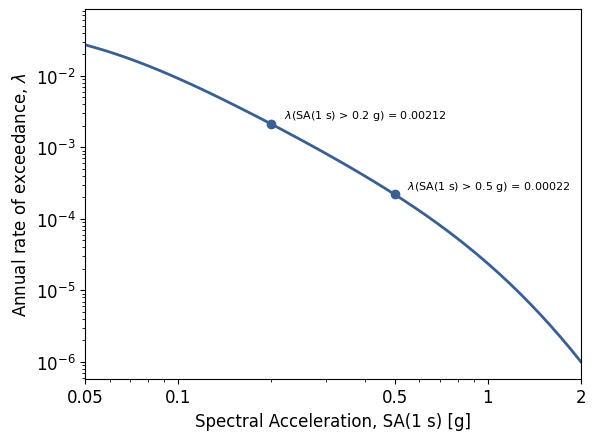

In [20]:
# Hazard curve plot
fig, ax = plt.subplots()
ax.loglog(x, lambda_['x'], '-', linewidth=2, color=colorspec[0])
ax.plot(x_example, lambda_['example'], 'o', color=colorspec[0])
ax.plot(x_example2, lambda2['example'], 'o', color=colorspec[0])

# Annotate text results for example cases
text1 = f"$\lambda$({IM_label} > {x_example} g) = {lambda_['example'][0]:.3g}"
text2 = f"$\lambda$({IM_label} > {x_example2} g) = {lambda2['example'][0]:.3g}"
ax.text(x_example * 1.1, lambda_['example'][0] * 1.2, text1, fontsize=8)
ax.text(x_example2 * 1.1, lambda2['example'][0] * 1.2, text2, fontsize=8)

plt.xlabel(Axis_label)
plt.ylabel('Annual rate of exceedance, $\lambda$')
ax.set_xscale('log')
plt.xlim([0.05, 2])
plt.xticks([0.05, 0.1, 0.5, 1,  2], ['0.05', '0.1', '0.5', '1', '2'])


plt.show()



In [13]:
# Output a subset of the hazard curve for use in a table
imSmall = np.array([1e-3] + list(np.arange(0.1, 1.1, 0.1)))
ratesSmall = np.exp(interp1d(np.log(x), np.log(lambda_['x']), kind='linear', fill_value='extrapolate')(np.log(imSmall)))
hazTable = np.column_stack((imSmall, ratesSmall))

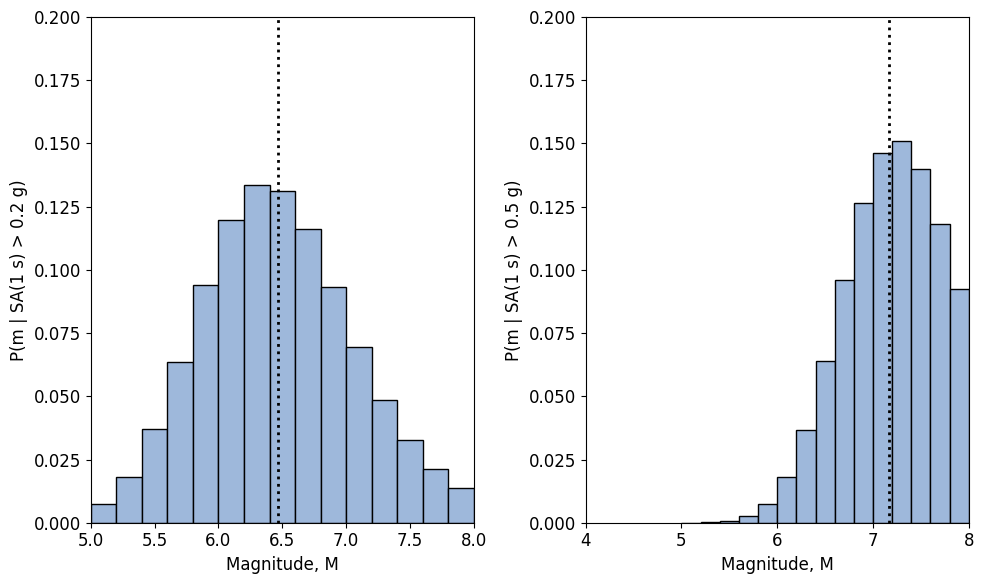

In [14]:
# Disaggregation plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(M_vals, disagg['example'], width=0.2, color=colorspec[2], edgecolor='black')
plt.plot([disagg['Mbar'], disagg['Mbar']], [0, 1], ':k', linewidth=2)
plt.xlabel('Magnitude, M')
plt.ylabel(f'P(m | {IM_label} > {x_example} g)')
plt.axis([5, 8, 0, 0.2])

plt.subplot(1, 2, 2)
plt.bar(M_vals, disagg2['example'], width=0.2, color=colorspec[2], edgecolor='black')
plt.plot([disagg2['Mbar'], disagg2['Mbar']], [0, 1], ':k', linewidth=2)
plt.xlabel('Magnitude, M')
plt.ylabel(f'P(m | {IM_label} > {x_example2} g)')
# plt.axis([5, 8, 0, 0.2])
plt.ylim([0, 0.2])
plt.xlim([4,8])

plt.tight_layout()

In [15]:
mBar = [disagg['Mbar'], disagg2['Mbar']]

# Tabulate output
disagg_table = np.column_stack((M_vals, disagg['example'], disagg2['example']))

# Metrics to evaluate calculations and figure
# Interpolate IM with given rate
rateTarg = 1 / 1000
imTarg = np.exp(interp1d(np.log(ratesSmall), np.log(imSmall), kind='linear', fill_value='extrapolate')(np.log(rateTarg)))

# Manual log interpolation
lnImManual = ((np.log(0.2) - np.log(0.3)) * (np.log(1E-3) - np.log(6.81E-4))) / (np.log(2.7E-3) - np.log(6.81E-4)) + np.log(0.3)
imManual = np.exp(lnImManual)

# Hazard curves slope
imSlope = [0.2, 0.3]
rateSlope = np.exp(interp1d(np.log(x), np.log(lambda_['x']), kind='linear', fill_value='extrapolate')(np.log(imSlope)))
kEst = - (np.log(rateSlope[0]) - np.log(rateSlope[1])) / (np.log(imSlope[0]) - np.log(imSlope[1]))
k0Est = rateSlope[0] / np.exp(-kEst * np.log(imSlope[0]))
lambdaPowerLaw = k0Est * np.exp(-kEst * np.log(x))

# Hazard curve derivative
dLambda = -np.diff(np.concatenate((ratesSmall, [0])))

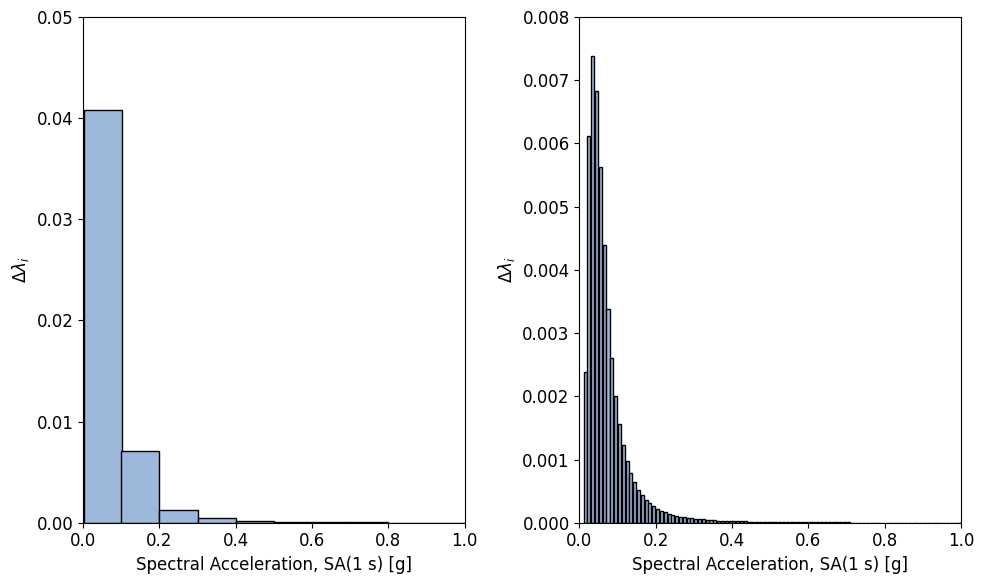

In [16]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(imSmall + 0.05, dLambda, width=0.10, color=colorspec[2], edgecolor='black')
plt.axis([0, 1, 0, 0.05])
# plt.text(-0.1, -0.07, '(a)', transform=plt.gca().transAxes, verticalalignment='center')
plt.xlabel(Axis_label)
plt.ylabel('$\Delta \lambda_i$')

plt.subplot(1, 2, 2)
xFine = np.arange(0.01, 1.01, 0.01)
lambdaFine = np.exp(interp1d(np.log(x), np.log(lambda_['x']), kind='linear', fill_value='extrapolate')(np.log(xFine)))
dLambdaFine = -np.diff(np.concatenate((lambdaFine, [0])))
plt.bar(xFine + 0.005, dLambdaFine, width=0.008, color=colorspec[2],edgecolor='black')
plt.axis([0, 1, 0, 0.008])
plt.xlabel(Axis_label)
plt.ylabel('$\Delta \lambda_i$')

plt.tight_layout()

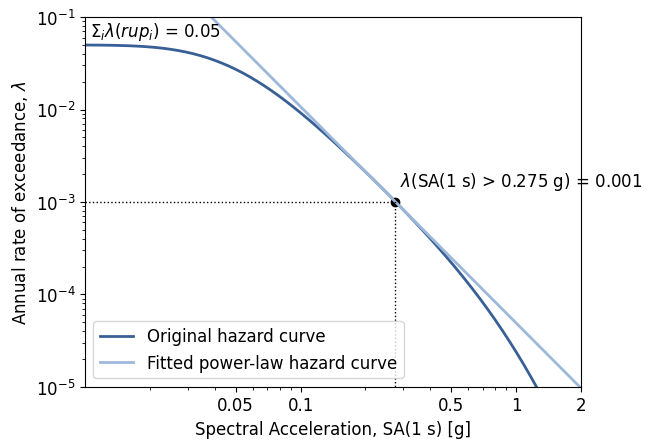

In [21]:
# Summary plot
plt.figure()
h1 = plt.loglog(x, lambda_['x'], '-', linewidth=2, color=colorspec[0], label='Original hazard curve')
plt.plot(imTarg, rateTarg, 'ok')
h2 = plt.plot(x, lambdaPowerLaw, '-', linewidth=2, color=colorspec[2], label='Fitted power-law hazard curve')
plt.plot([0.01, imTarg, imTarg], [rateTarg, rateTarg, 1e-10], ':k', linewidth=1)
plt.text(imTarg * 1.05, rateTarg * 1.5, f'$\lambda$({IM_label} > {imTarg:.3g} g) = {rateTarg:.3g}')
plt.text(0.01 * 1.05, lambda_M[0] * 1.25, f'$\Sigma_i \lambda(rup_i)$ = {lambda_M[0]}')

plt.legend(handles=[h1[0], h2[0]])
plt.xlabel(Axis_label)
plt.ylabel('Annual rate of exceedance, $\lambda$')
plt.xlim([0.01,2])
plt.ylim([10e-6,10e-2])
plt.xticks([0.05, 0.1, 0.5, 1, 2], ['0.05', '0.1', '0.5', '1', '2'])
plt.show()